Layer: 1, MLP: 4.1372, Transformer: 4.5026, FANformer: 6.1521
Layer: 2, MLP: 7.0347, Transformer: 7.3858, FANformer: 11.2465
Layer: 4, MLP: 12.3073, Transformer: 13.0271, FANformer: 24.0606
Layer: 8, MLP: 21.8128, Transformer: 25.6761, FANformer: 103.6567
Layer: 12, MLP: 30.3452, Transformer: 51.2796, FANformer: 407.3611
Layer: 16, MLP: 38.2069, Transformer: 79.7350, FANformer: 1439.2750
Layer: 24, MLP: 53.3033, Transformer: 225.3611, FANformer: 16732.4648
Layer: 32, MLP: 67.1360, Transformer: 780.3786, FANformer: 249972.9688
Layer: 48, MLP: 92.4646, Transformer: 5943.2651, FANformer: 8715475.0000
Layer: 64, MLP: 116.2845, Transformer: 25165.5430, FANformer: 10726869.0000
Layer: 80, MLP: 138.9805, Transformer: 480086.3438, FANformer: 10515426.0000
Layer: 96, MLP: 159.9807, Transformer: 3143030.5000, FANformer: 10794753.0000
Layer: 128, MLP: 201.4600, Transformer: 8724885.0000, FANformer: 10368053.0000
Layer: 160, MLP: 240.2821, Transformer: 8482305.0000, FANformer: 10770551.0000
Layer:

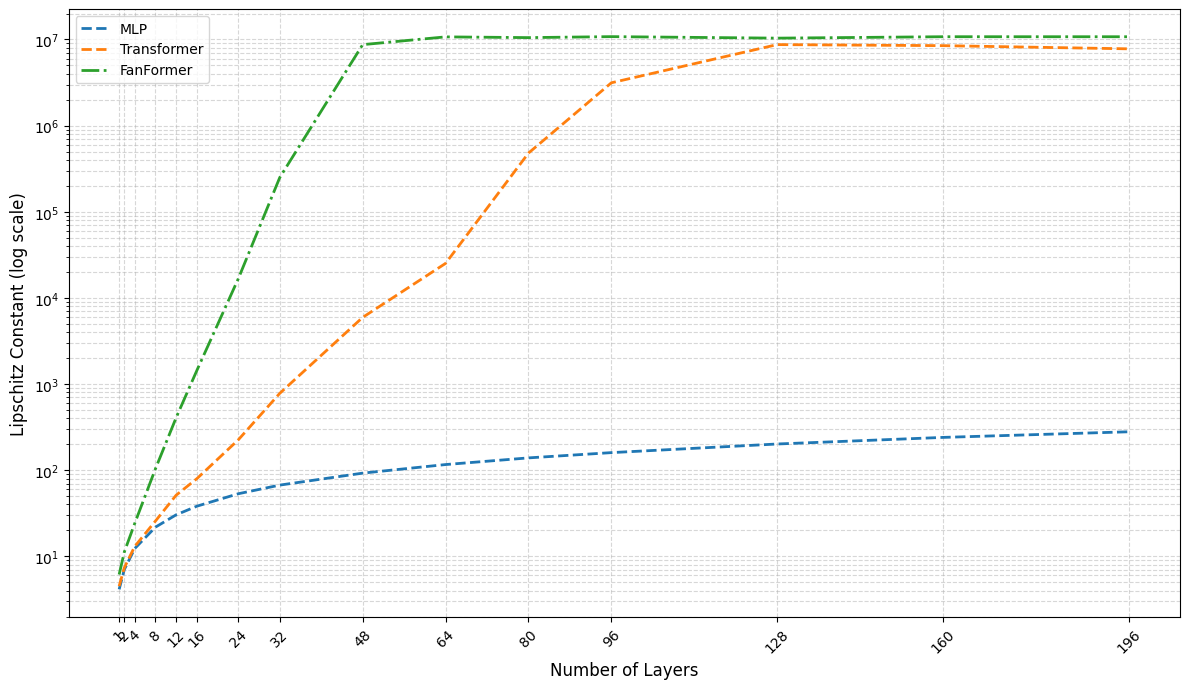

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import random

# Set random seeds for reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return out

class MLP(nn.Module):
    def __init__(self, block, num_blocks, dim):
        super(MLP, self).__init__()
        self.block_number = num_blocks
        self.in_channels = dim
        self.blocks = []
        for i in range(num_blocks):
            self.blocks.append(BasicBlock(dim, dim))
            
    def forward(self, x):
        tmp_x = x
        for i in range(self.block_number):
            tmp_x = self.blocks[i](tmp_x)
        return tmp_x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads."

        self.head_dim = embed_dim // num_heads
        self.q = nn.Linear(embed_dim, embed_dim)
        self.k = nn.Linear(embed_dim, embed_dim)
        self.v = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        batch_size = x.shape[0]
        q = self.q(x).view(batch_size, -1, self.num_heads, self.head_dim)
        k = self.k(x).view(batch_size, -1, self.num_heads, self.head_dim)
        v = self.v(x).view(batch_size, -1, self.num_heads, self.head_dim)
        
        q = q.permute(0,2,1,3)
        k = k.permute(0,2,1,3)
        v = v.permute(0,2,1,3)

        energy = torch.einsum("nqhd,nkhd->nhqk", [q, k])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_dim ** (1/2)), dim=-1)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, v]).permute(0, 2, 1, 3).contiguous()
        out = out.view(batch_size, -1, self.embed_dim)

        return self.fc_out(out)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion=4):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim),
        )

    def forward(self, x, mask=None):
        attention = self.attention(x, mask)
        x = self.norm1(attention + x)
        forward = self.feed_forward(x)
        out = self.norm2(forward + x)
        return out

class Transformer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, forward_expansion):
        super(Transformer, self).__init__()
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_dim, num_heads, forward_expansion) for _ in range(num_layers)]
        )

    def forward(self, x, mask=None):
        out = x
        for layer in self.layers:
            out = layer(out, mask)
        return out

# Modified FANLayer
class FANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, p_ratio=0.25, activation=None, use_p_bias=True):
        super(FANLayer, self).__init__()
        assert 0 <= p_ratio <= 0.5, "p_ratio must be between 0 and 0.5"
        
        self.p_ratio = p_ratio
        p_output_dim = int(output_dim * self.p_ratio)
        g_output_dim = output_dim - p_output_dim * 2
        
        self.input_linear = nn.Linear(input_dim, p_output_dim+g_output_dim, bias=use_p_bias)
        self.fused_dims = (p_output_dim, g_output_dim)
        
        # Set the activation function
        if isinstance(activation, str):
            self.activation = getattr(F, activation)
        else:
            self.activation = activation if activation else lambda x: x

    def forward(self, src, norm_g=None):
        pg = self.input_linear(src)
        p, g = pg.split(self.fused_dims, dim=-1)
        output = torch.cat((torch.cos(p), torch.sin(p), self.activation(g)), dim=-1)
        return output

# Modified FAN
class FAN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FAN, self).__init__()
        self.fanlayer = FANLayer(input_dim, input_dim, 0.25)
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, src):
        return self.linear(self.fanlayer(src))

class MultiHeadAttention_FAN(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention_FAN, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by the number of heads."

        self.head_dim = embed_dim // num_heads
        # Modified FAN
        self.q = FAN(embed_dim, embed_dim)
        self.k = FAN(embed_dim, embed_dim)
        self.v = FAN(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        batch_size = x.shape[0]
        q = self.q(x).view(batch_size, -1, self.num_heads, self.head_dim)
        k = self.k(x).view(batch_size, -1, self.num_heads, self.head_dim)
        v = self.v(x).view(batch_size, -1, self.num_heads, self.head_dim)
        
        q = q.permute(0,2,1,3)
        k = k.permute(0,2,1,3)
        v = v.permute(0,2,1,3)

        energy = torch.einsum("nqhd,nkhd->nhqk", [q, k])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_dim ** (1/2)), dim=-1)
        out = torch.einsum("nhql,nlhd->nqhd", [attention, v]).permute(0, 2, 1, 3).contiguous()
        out = out.view(batch_size, -1, self.embed_dim)

        return self.fc_out(out)

class TransformerBlock_FAN(nn.Module):
    def __init__(self, embed_dim, num_heads, forward_expansion=4):
        super().__init__()
        self.attention = MultiHeadAttention_FAN(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion * embed_dim),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_dim, embed_dim),
        )

    def forward(self, x, mask=None):
        attention = self.attention(x, mask)
        x = self.norm1(attention + x)
        forward = self.feed_forward(x)
        out = self.norm2(forward + x)
        return out

class FANformer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers, forward_expansion):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerBlock_FAN(embed_dim, num_heads, forward_expansion) 
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        out = x
        for layer in self.layers:
            out = layer(out, mask)
        return out

# Model parameters
embed_dim = 512
num_heads = 8
forward_expansion = 4
K = 32
B = 10

# He initialization factor
factor = np.sqrt(2.0)
episilon_factor = 0.0000001

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, gain=factor)
        if m.bias is not None:
            m.bias.data.fill_(0.0)

# Experimental setup
x = torch.randn(B, embed_dim, K, K)
episilon = episilon_factor * torch.randn(B, embed_dim, K, K)

# Layer configurations for experiments
layers = [1, 2, 4, 8, 12, 16, 24, 32, 48, 64, 80, 96, 128, 160, 196]

# Initialize result storage
result_mlp = []
result_transformer = []
result_fanformer = []

# Main experimental loop
for L in layers:
    # Initialize models
    transformer = Transformer(embed_dim, 8, L, 4)
    transformer.apply(init_weights)

    mlp = MLP(BasicBlock, L, embed_dim)
    mlp.apply(init_weights)
    
    fanformer = FANformer(embed_dim, 8, L, 4)
    fanformer.apply(init_weights)

    with torch.no_grad():
        x1 = x
        y1_mlp = mlp(x1)

        x1_transformed = torch.reshape(x, [B, embed_dim, K*K]).transpose(2, 1)
        y1_transformer = transformer(x1_transformed)
        y1_fanformer = fanformer(x1_transformed)

        x2 = x + episilon
        y2_mlp = mlp(x2)

        x2_transformed = torch.reshape(x2, [B, embed_dim, K*K]).transpose(2, 1)
        y2_transformer = transformer(x2_transformed)
        y2_fanformer = fanformer(x2_transformed)

        # Calculate Lipschitz constants
        x1_flat = torch.reshape(x1_transformed, [B, embed_dim*K*K])
        x2_flat = torch.reshape(x2_transformed, [B, embed_dim*K*K])
        y1_mlp_flat = torch.reshape(y1_mlp, [B, embed_dim*K*K])
        y2_mlp_flat = torch.reshape(y2_mlp, [B, embed_dim*K*K])
        y1_transformer_flat = torch.reshape(y1_transformer, [B, embed_dim*K*K])
        y2_transformer_flat = torch.reshape(y2_transformer, [B, embed_dim*K*K])
        y1_fanformer_flat = torch.reshape(y1_fanformer, [B, embed_dim*K*K])
        y2_fanformer_flat = torch.reshape(y2_fanformer, [B, embed_dim*K*K])

        # Compute Lipschitz constants
        lips_mlp = torch.max(torch.sqrt(torch.sum(torch.pow(y2_mlp_flat-y1_mlp_flat, 2), axis=1) / 
                                      torch.sum(torch.pow(x2_flat-x1_flat, 2), axis=1)))
        lips_transformer = torch.max(torch.sqrt(torch.sum(torch.pow(y2_transformer_flat-y1_transformer_flat, 2), axis=1) / 
                                              torch.sum(torch.pow(x2_flat-x1_flat, 2), axis=1)))
        lips_fanformer = torch.max(torch.sqrt(torch.sum(torch.pow(y2_fanformer_flat-y1_fanformer_flat, 2), axis=1) / 
                                            torch.sum(torch.pow(x2_flat-x1_flat, 2), axis=1)))

        # Store results
        result_mlp.append(lips_mlp.item())
        result_transformer.append(lips_transformer.item())
        result_fanformer.append(lips_fanformer.item())

        print(f'Layer: {L}, MLP: {lips_mlp:.4f}, Transformer: {lips_transformer:.4f}, FANformer: {lips_fanformer:.4f}')

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.yscale('log')
plt.plot(layers, result_mlp, linestyle='--', linewidth=2, label='MLP')
plt.plot(layers, result_transformer, linestyle='--', linewidth=2, label='Transformer')
plt.plot(layers, result_fanformer, linestyle='-.', linewidth=2, label='FanFormer')

plt.xlabel('Number of Layers', fontsize=12)
plt.ylabel('Lipschitz Constant (log scale)', fontsize=12)
plt.xticks(layers, rotation=45)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()